# Writing Custom Dataset, Dataloader and Transformers

Pratice with custom dataset

soruce:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=csv

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

Lets take a single image name and its annotation from the csv. In this case row index number 65 for person 7 just as an example. 

We need to read it, store the image name in img_name and store its annotation in a (l, 2) array landmarks where l is the number of landmarks in that row

In [3]:
import os
current_directory = os.getcwd()
print(current_directory)

/Users/eric/Documents/GitHub/pytorch-custom-dataset


In [4]:
landmarks_frame = pd.read_csv('../pytorch-custom-dataset/data/faces/face_landmarks.csv')

In [5]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

In [6]:
print(f'Image name: {img_name}')
print(f'landmarks shape: {landmarks.shape}')
print(f'First 4 landmarks: {landmarks[:4]}')

Image name: person-7.jpg
landmarks shape: (68, 2)
First 4 landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Creating a simple helper functoin to show an image and its landmarks and use it show a sample

In [7]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c="r")
    plt.pause(0.001)

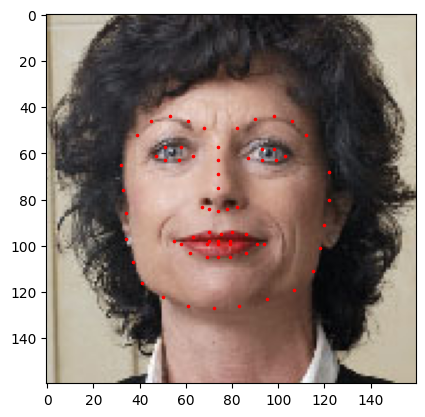

In [8]:
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)

plt.show()

## Dataset class

data.Dataset is an abstract class representing a dataset. The custom dataset show inherit Dataset and override the following methods:

- __len__ so that len(dataset) returns the size of the dataset
- __getitem__ to support the indexing such that dataset[i] can be used to get ith sample

lets create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. This memory efficient because all the images are not stored in the memory at once but read as required. 

Sample of our dataset will be dict {'image': image, 'landmark': landmarks}. Our dataset will take an optional argument transform so that any require processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [9]:
class FaceLandmarksDataset(Dataset):
    """Face Landmark dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """ 
        Arguments:
            csv_file (string): path to the csv file with annotations
            root_dir (string): Directory with all the images
            transofrm (callable, optional): optional transform to be applied on sample
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {'image': image, 'landmarks':landmarks}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

lets instantiate this class and iterate through the data samples. 

We will print the sizes of first 4 samples and show their landmarks.

In [10]:
face_dataset = FaceLandmarksDataset(csv_file='../pytorch-custom-dataset/data/faces/face_landmarks.csv',
                                    root_dir='../pytorch-custom-dataset/data/faces/')

0 (324, 215, 3) (68, 2)


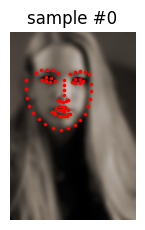

1 (500, 333, 3) (68, 2)


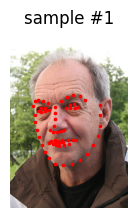

2 (250, 258, 3) (68, 2)


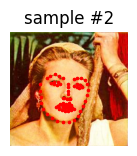

3 (434, 290, 3) (68, 2)


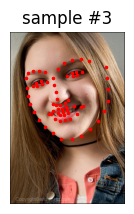

In [11]:
fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'sample #{i}')
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### Transform

One issue we cna see from the above sampels are not of the same size . Most neural networks expect the images of a fixed size. Therefore, we will need to write some preprocessing code. We will need three transforms:
- Recale: to scale the image
- RandomCrop: to crop from image randomly. This is data augmentation
- ToTensor: to convert the numpy images to torch images ( we need to swap axes)

We will write them as callable classes of simple functions so that parameters of the transform need not be passed every time its called. For this, we just need to implement __call__ method and if required __init__ method. 

In [12]:
from typing import Any


class Rescale(object):
    """Recale the image in a sample to a given size
    
    args:
        output_size (tuple or int): desire output size. If tuple, outptu is 
        matched to output_size. If int, smaller of image edges is matched to output_size 
        keeping aspect ratio the same
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        # h and w are swapped for landmarks becasue for imges
        #  x and y are axis 1 and 0 respectively

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

In [13]:
class RandomCrop(object):
    """crop randomly the image in a sample
    
    args:
        output_size (tuple or int): desired output size. If int, square crop is made
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [14]:
class ToTensor(object):
    """converts ndarrays in sample to tensors"""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: h x w X c
        # torch image; c x h x w
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### Compose transforms

Now, we apply the transforms on a sample.

lets say we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it. i.e, we want to compose Rescale and RandomCrop transforms. Compose is a simple callable class which allows us to do this.

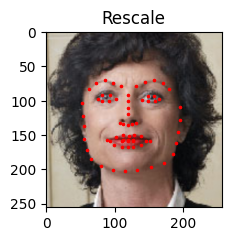

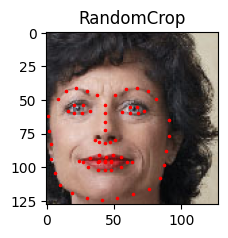

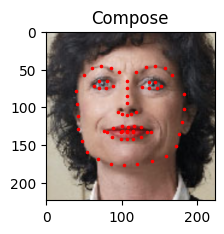

In [15]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# apply each of the above transforms on sample
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transform_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transform_sample)

plt.show()